# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train_cleaned.csv')
test_df = pd.read_csv('test_cleaned.csv')

In [3]:
train_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
test_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


# Creating New Features

To ensure the new features we created are indeed sinificant for predicting our target variable, we can establish an ANOVA test to validate it.

In [5]:
# define a function for the ANOVA test
def anova_test(feature):

    grouped_data = [train_df[train_df['NObeyesdad']==label][feature] for label in train_df['NObeyesdad'].unique()]

    F, p = stats.f_oneway(*grouped_data)

    if p<0.05:
        print(f"The p-value for {feature} is {p}, there is a significant difference in {feature} among the target groups.")
    else:
        print(f"The p-value for {feature} is {p}, there is no significant difference in {feature} among the target groups.")

## BMI

**Body Mass Index (BMI)** is a widely used measure to classify underweight, overweight, and obesity in adults. It is calculated based on the individual’s height and weight, and it provides a simple numeric measure of a person's thickness or thinness, allowing health professionals to discuss weight problems more objectively with their patients. This feature could potentially improve our model's performance. BMI formula is the following:

$$BMI = \frac{weight (kg)}{height (m)^2}$$

In [6]:
# define a function to calculate BMI
def bmi_calculator(height, weight):
    
    bmi = weight / (height**2)
    
    return bmi

In [7]:
# calculate bmi and apply the function to train and test sets
dfs = [train_df, test_df]

for dataframe in dfs:
    dataframe['BMI'] = dataframe.apply(lambda x: bmi_calculator(x['Height'], x['Weight']), axis=1)

Now, we are using the ANOVA test to validate the correlation with the target variable.

In [8]:
anova_test('BMI')

The p-value for BMI is 0.0, there is a significant difference in BMI among the target groups.


## Activity Score

To develop a deeper understanding of an individual's lifestyle balance, we can calculate a feature that measures the difference between their physical activity frequency and their time spent using technology devices. This difference could provide a useful metric to gauge the healthiness of a person’s daily routine. Higher this score is, the healthier the person is, smaller the score is (or negative) means this person is spending more time on their screens. Since `FAF` has a larger scale than `TUE` we are multiplying `TUE` by 1.5 first.

In [9]:
train_df[['FAF','TUE']].describe()

,FAF,TUE
count,20758.000000,20758.000000
mean,0.981747,0.616756
std,0.838302,0.602113
min,0.000000,0.000000
25%,0.008013,0.000000
50%,1.000000,0.573887
75%,1.587406,1.000000
max,3.000000,2.000000


In [10]:
# apply to datasets
for dataframe in dfs:
    
    dataframe['Activity_Score'] = dataframe.apply(lambda x: x['FAF']-1.5*x['TUE'], axis=1)

In [11]:
# validate significance
anova_test('Activity_Score')

The p-value for Activity_Score is 4.40916885091697e-186, there is a significant difference in Activity_Score among the target groups.


# Encoding Ordinal Labels

The features `CAEC` (Consumption of food between meals) and `CALC` (Consumption of alcohol) can be encoded as ordinal labels to effectively capture the linear relationship inherent in their ordered categories, enhancing the model's ability to interpret them.

In [12]:
# check unique values
print(train_df['CAEC'].value_counts())
print('\n')
print(train_df['CALC'].value_counts())

Sometimes     17529
Frequently     2472
Always          478
no              279
Name: CAEC, dtype: int64


Sometimes     15066
no             5163
Frequently      529
Name: CALC, dtype: int64


In [13]:
# create ordinal mappings
ordinal_mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

# apply to both train and test sets
for dataframe in dfs:
    dataframe['CAEC'] = dataframe['CAEC'].map(ordinal_mapping)
    dataframe['CALC'] = dataframe['CALC'].map(ordinal_mapping)

In [14]:
# check results
print(train_df['CAEC'].value_counts())
print('\n')
print(train_df['CALC'].value_counts())

1    17529
2     2472
3      478
0      279
Name: CAEC, dtype: int64


1    15066
0     5163
2      529
Name: CALC, dtype: int64


# One-Hot Encoding

One-hot encoding is a process used to convert categorical variables into a form that could be provided to ML algorithms to do a better job in prediction. It converts each categorical class into a new binary variable (0 or 1). This technique is particularly useful for handling categorical data without imposing ordinality (where the order of categories is not meaningful).

In [15]:
# get categorical features 
cat_features = train_df.drop(columns='NObeyesdad').select_dtypes(include='object').columns
cat_features

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC',
       'MTRANS'],
      dtype='object')

In [16]:
train_df = pd.get_dummies(train_df, columns=cat_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cat_features, drop_first=True)

# Scale Numerical Features

Note that numerical features in the datasets are on different scales, making it essential to standardize them to the same scale. This ensures that models will treat all features equally, preventing any one feature with a larger range from dominating the learning algorithm. By normalizing the features, we help improve the convergence speed of gradient-based optimization algorithms and increase the overall predictive performance of the model.

From previous EDA and hypothesis testing for normality of the numerical features, we see that none of the features is normally distributed and some columns do contain outliers, making RobustScaler a suitable choice to prevent the extreme values from influencing the scale of the entire dataset.

In [17]:
# get numerical features
num_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'BMI', 'Activity_Score']

# instantiate RobustScaler
rs = RobustScaler()

# fit the scaler and transform
train_df[num_features] = rs.fit_transform(train_df[num_features])
test_df[num_features] = rs.transform(test_df[num_features])

# Check Multicollinearity

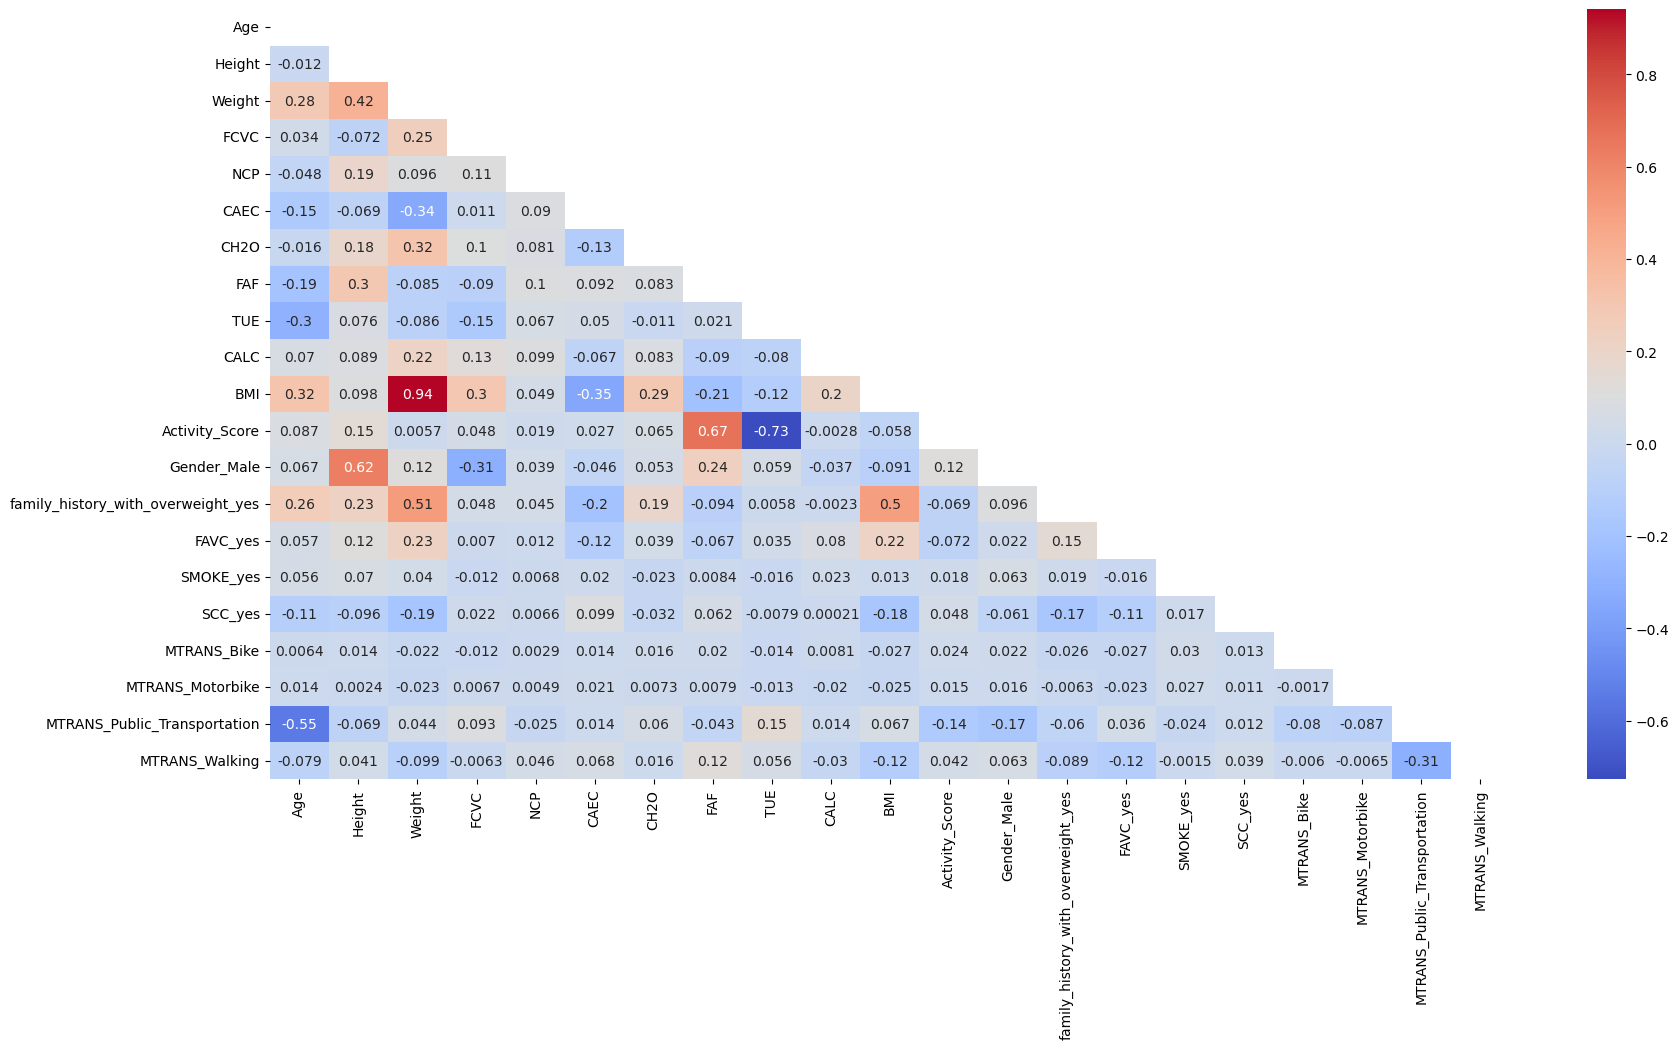

In [26]:
corr_matrix = train_df.corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,
           mask=mask,
           annot=True,
           cmap='coolwarm')

plt.show()

There is multicollinearity present from the features we engineered, but they are not going to influence the model, if we are using non-linear models like tree-based models or SVMs.

# Export

In [29]:
train_df.to_csv('train_preprocessed.csv', index=False)
test_df.to_csv('test_preprocessed.csv', index=False)